In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Dense, MaxPool2D, Conv2D, Dropout, Flatten, GlobalAveragePooling2D, Input
from keras.models import Sequential
from keras.utils import np_utils, to_categorical
from keras.datasets import cifar10
import keras.backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test,y_test) = cifar10.load_data()
print("X_train -> ",X_train.shape)
print("y_train -> ",y_train.shape)
print("X_test  -> ",X_test.shape)
print("y_test  -> ",y_test.shape)

X_train ->  (50000, 32, 32, 3)
y_train ->  (50000, 1)
X_test  ->  (10000, 32, 32, 3)
y_test  ->  (10000, 1)


In [3]:
X_train = X_train.reshape(50000, 32*32, 3)
X_test = X_test.reshape(10000, 32*32, 3)
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

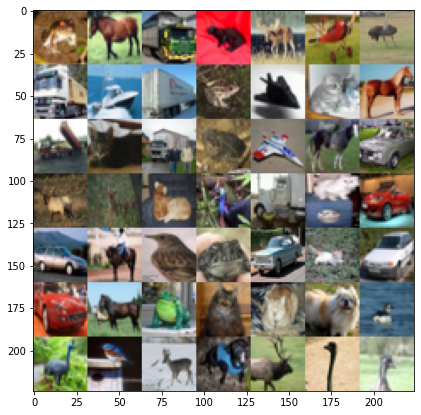

In [4]:
fig, ax = plt.subplots(figsize=(7, 7))
X_to_plot = X_train[:49, :, :]
X_to_plot = np.concatenate([
                    X_to_plot[  : 7, ...].reshape(32*7, 32, 3),
                    X_to_plot[ 7:14, ...].reshape(32*7, 32, 3),
                    X_to_plot[14:21, ...].reshape(32*7, 32, 3),
                    X_to_plot[21:28, ...].reshape(32*7, 32, 3),
                    X_to_plot[28:35, ...].reshape(32*7, 32, 3),
                    X_to_plot[35:42, ...].reshape(32*7, 32, 3),
                    X_to_plot[42:49, ...].reshape(32*7, 32, 3)
                ], axis=1
            )
ax.imshow(X_to_plot)

In [5]:
X_train, X_test = X_train.reshape(50000, 32, 32, 3), X_test.reshape(10000, 32, 32, 3)

In [6]:
X_train_ = np.array([cv2.resize(X_train[i], dsize=(72,72)) for i in range(len(X_train))]).astype('float64')
X_test_ = np.array([cv2.resize(X_test[i], dsize=(72,72)) for i in range(len(X_test))]).astype('float64')

In [7]:
X_train_ = preprocess_input(X_train_)
X_test_ = preprocess_input(X_test_)

In [8]:
print(X_train_.shape)
print(X_test_.shape)

(50000, 72, 72, 3)
(10000, 72, 72, 3)


In [9]:
model_pretrained = Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(72, 72, 3), pooling=None)

In [10]:
model = Sequential()
model.add(Input(shape=[3, 3, 2048]))
model.add(GlobalAveragePooling2D())
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               819600    
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                4010      
Total params: 823,610
Trainable params: 823,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
BATCH_SIZE = 512

def startit(func):
    def _started_func(*args, **kwargs):
        func_started = func(*args, **kwargs)
        func_started.send(None)
        return func_started
    return _started_func

@startit
def train_generator_fn():
    i = 0
    while True:
        if i > 50000:
            i = 0
        X_batch = model_pretrained.predict(X_train_[i:i+BATCH_SIZE, ...])
        y_batch = y_train[i:i+BATCH_SIZE, ...]
        i += BATCH_SIZE
        yield np.asarray(X_batch), np.asarray(y_batch)

@startit
def test_generator_fn():
    i = 0
    while True:
        if i > 50000:
            i = 0
        X_batch = model_pretrained.predict(X_test_[i:i+BATCH_SIZE, ...])
        y_batch = y_test[i:i+BATCH_SIZE, ...]
        i += BATCH_SIZE
        yield np.asarray(X_batch), np.asarray(y_batch)

In [13]:
model.fit(train_generator_fn(), epochs=10, steps_per_epoch=50000 // BATCH_SIZE)

Epoch 1/10
97/97 [==============================] - 27s 276ms/step - loss: 1.2605 - accuracy: 0.5918
Epoch 2/10
97/97 [==============================] - 26s 273ms/step - loss: 0.7417 - accuracy: 0.7461
Epoch 3/10
97/97 [==============================] - 26s 274ms/step - loss: 0.6507 - accuracy: 0.7748
Epoch 4/10
97/97 [==============================] - 27s 275ms/step - loss: 0.5834 - accuracy: 0.7972
Epoch 5/10
97/97 [==============================] - 27s 279ms/step - loss: 0.5267 - accuracy: 0.8180
Epoch 6/10
97/97 [==============================] - 27s 277ms/step - loss: 0.4769 - accuracy: 0.8352
Epoch 7/10
97/97 [==============================] - 27s 281ms/step - loss: 0.4309 - accuracy: 0.8512
Epoch 8/10
97/97 [==============================] - 27s 275ms/step - loss: 0.3880 - accuracy: 0.8687
Epoch 9/10
97/97 [==============================] - 27s 276ms/step - loss: 0.3535 - accuracy: 0.8778
Epoch 10/10
97/97 [==============================] - 27s 275ms/step - loss: 0.3156 - accura

In [14]:
model.evaluate(test_generator_fn(), steps=10000 // BATCH_SIZE)

19/19 [==============================] - 5s 271ms/step - loss: 0.7833 - accuracy: 0.7543


[0.783316433429718, 0.754321277141571]